
# Diabetes Progression Modeling



## Notebook Roadmap
- **Part 1:** Data, problem framing (with talking points), EDA, cleaning, and train/validation/test split.  
- **Part 2:** Univariate BMI → Target polynomial models (deg 0–5): comparison table, best model, test metrics, plot, equation, example prediction, parameter counts, conclusions (with talking points).  
- **Part 3:** Multivariate models: two polynomial degrees, two decision trees, two kNNs (with scaling), two logistic regressions (binarized screening). Tables + narrative; no plots required here.  
- **Conclusions & Limitations.**


## Part 1 - Data, Problem Framing, EDA, Cleaning, and Splits


### 1) Get the Data
We use `sklearn.datasets.load_diabetes(as_frame=True)` to obtain a DataFrame with features and the target. Optional args include `return_X_y`, `as_frame`, and `scaled` (see docs).


In [1]:

# Imports used throughout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_absolute_percentage_error,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
)

np.random.seed(42)

# Load diabetes dataset as DataFrame
diab = datasets.load_diabetes(as_frame=True)
df = diab.frame.copy()
df.rename(columns={"target": "progression"}, inplace=True)

feature_names = diab.feature_names
target_name = "progression"

df.head()


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0



### 2) Frame the Problem (with workshop talking points)
**Objective:** Predict **one‑year diabetes progression** (`progression`) for **screening**.

**Why these models & metrics?**  
- **Performance Metrics (Classification):** Beyond regression metrics ($R^2$, MAE, MAPE), screening often needs **Accuracy**, **Precision**, **Recall**, **F1**, **ROC‑AUC**, **LogLoss**; beware **class imbalance** (accuracy can mislead).  
- **kNN:** Non‑parametric, sensitive to **feature scaling**, impacted by the **curse of dimensionality**.  
- **Logistic Regression:** Probabilities via **sigmoid**; linear in **log‑odds**; **regularization (C)** helps prevent overfitting.


### 3) EDA - statistics, histograms, scatter, correlation, and insights

In [2]:

# Summary stats
desc = df.describe().T
desc


,count,mean,std,min,25%,50%,75%,max
age,442.0,-2.511817e-19,0.047619,-0.107226,-0.037299,0.005383,0.038076,0.110727
sex,442.0,1.230790e-17,0.047619,-0.044642,-0.044642,-0.044642,0.050680,0.050680
bmi,442.0,-2.245564e-16,0.047619,-0.090275,-0.034229,-0.007284,0.031248,0.170555
bp,442.0,-4.797570e-17,0.047619,-0.112399,-0.036656,-0.005670,0.035644,0.132044
s1,442.0,-1.381499e-17,0.047619,-0.126781,-0.034248,-0.004321,0.028358,0.153914
s2,442.0,3.918434e-17,0.047619,-0.115613,-0.030358,-0.003819,0.029844,0.198788
s3,442.0,-5.777179e-18,0.047619,-0.102307,-0.035117,-0.006584,0.029312,0.181179
s4,442.0,-9.042540e-18,0.047619,-0.076395,-0.039493,-0.002592,0.034309,0.185234
s5,442.0,9.293722e-17,0.047619,-0.126097,-0.033246,-0.001947,0.032432,0.133597
s6,442.0,1.130318e-17,0.047619,-0.137767,-0.033179,-0.001078,0.027917,0.135612


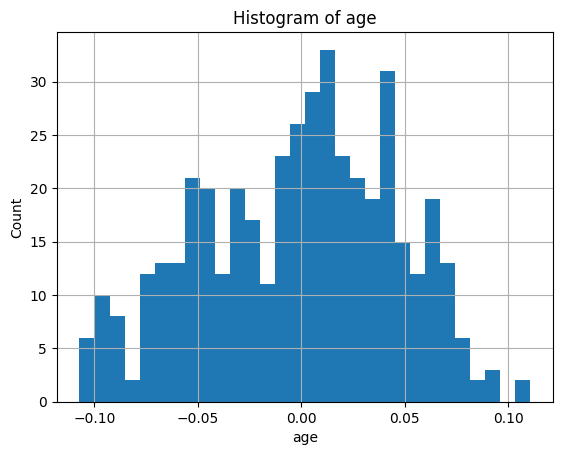

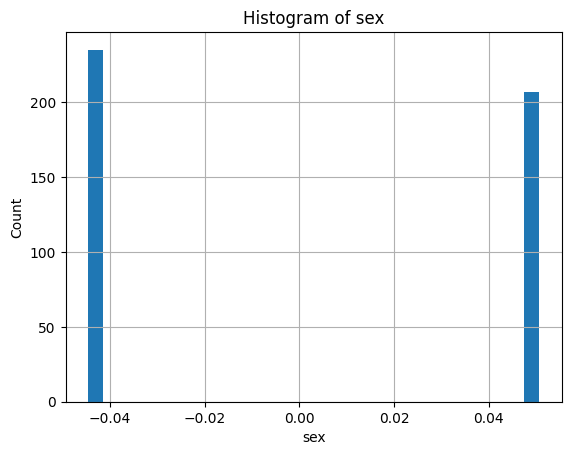

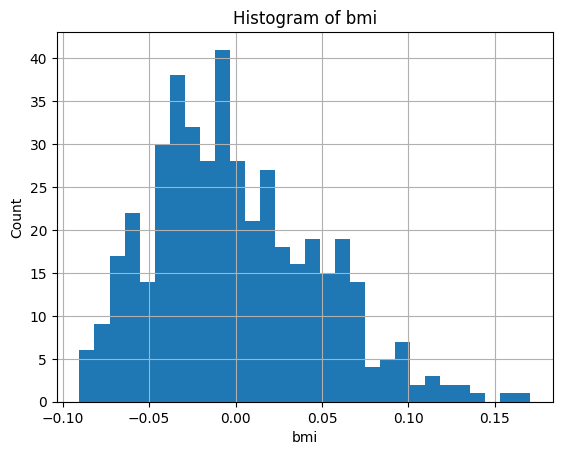

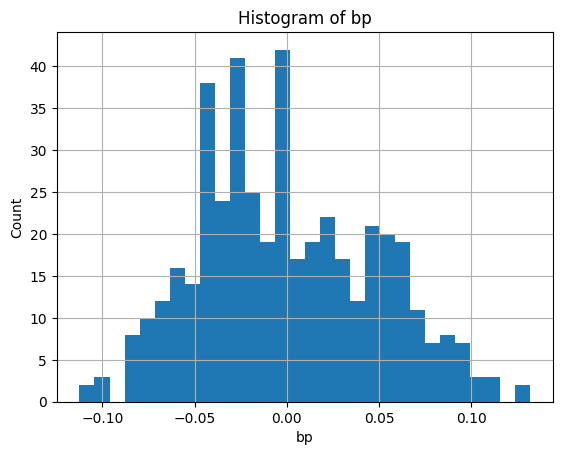

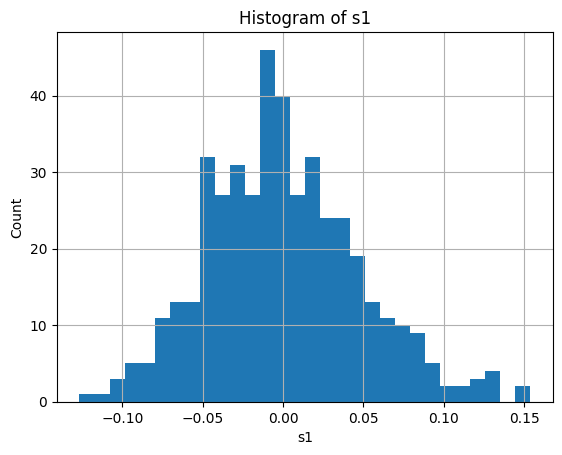

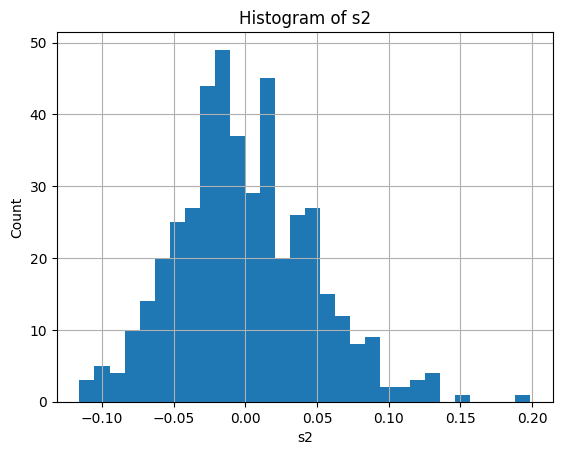

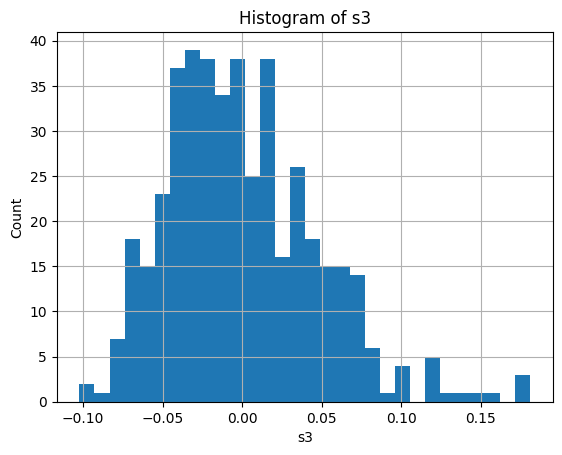

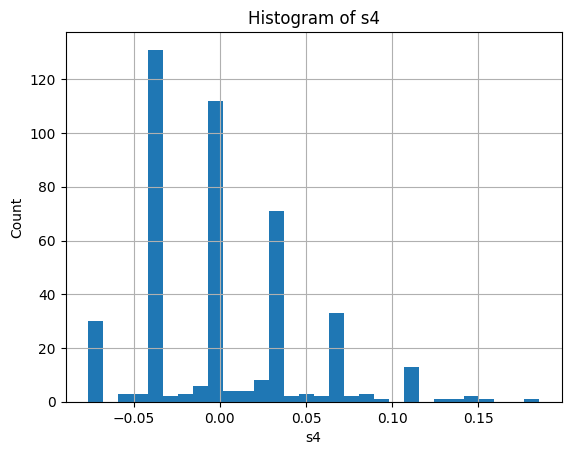

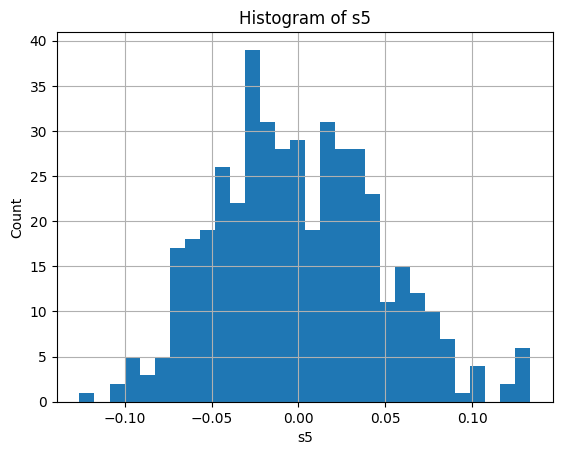

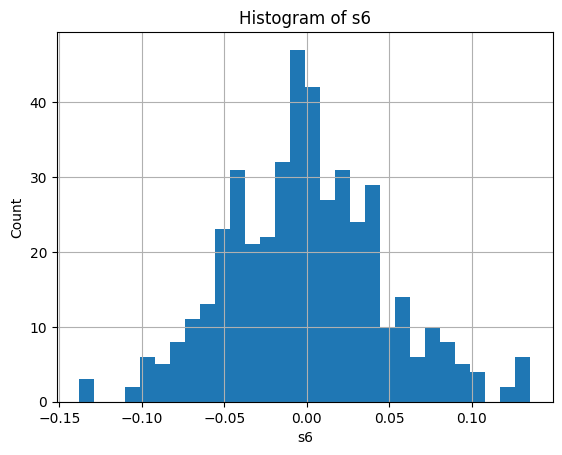

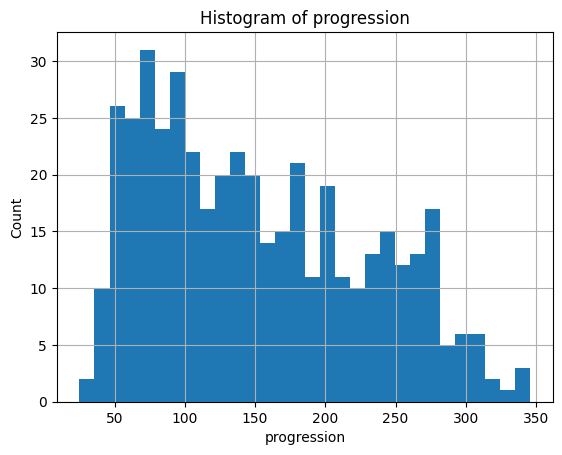

In [3]:

# Histograms for all variables
for col in df.columns:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()


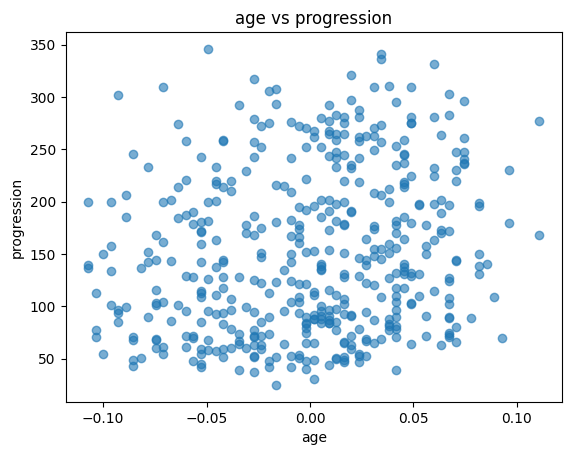

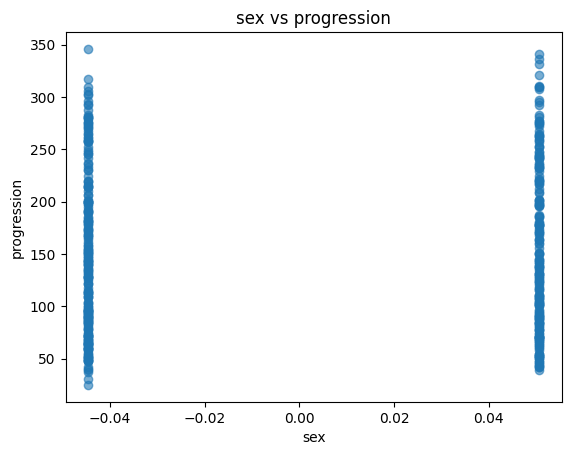

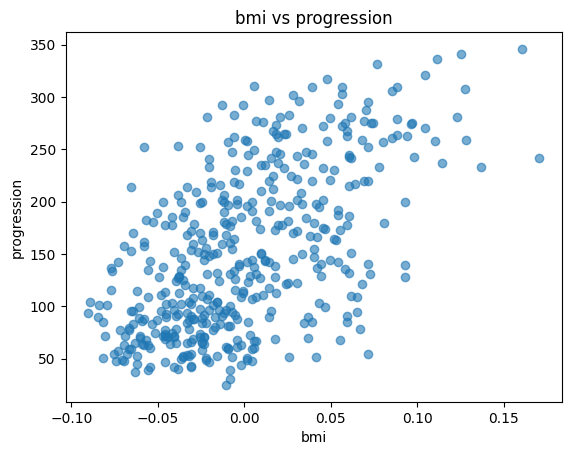

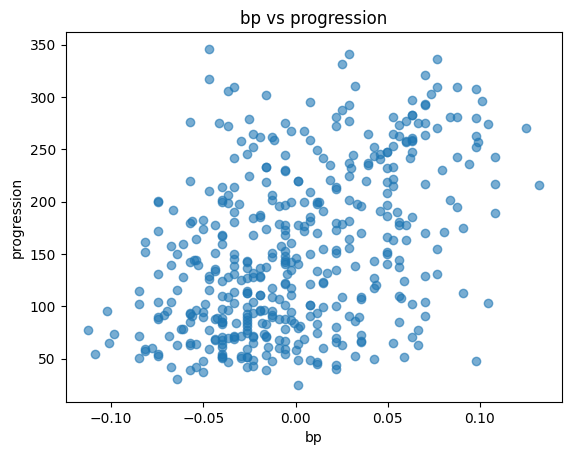

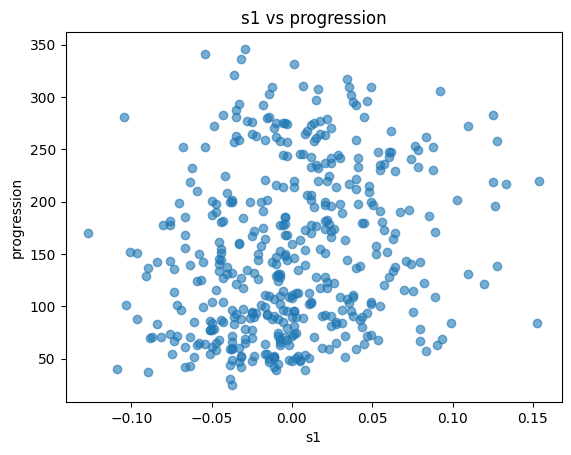

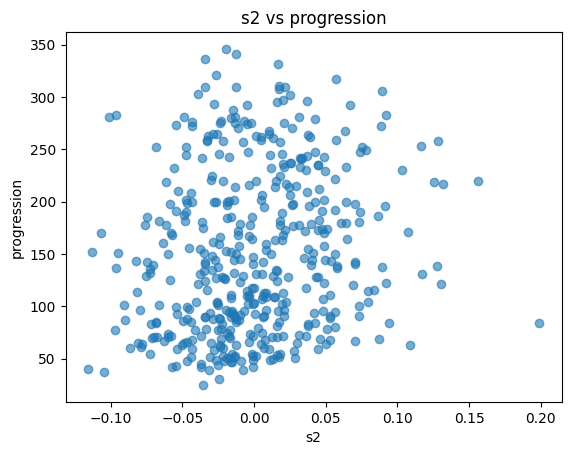

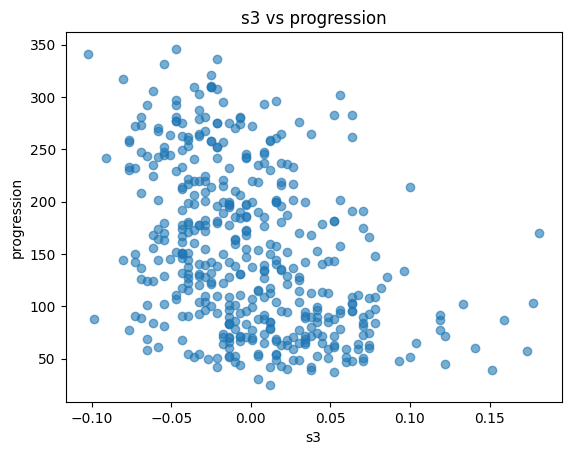

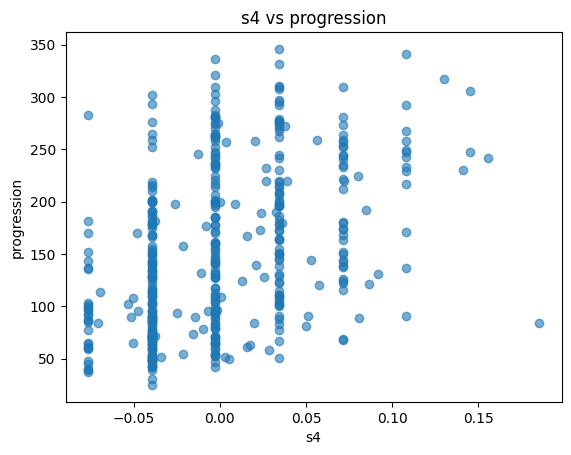

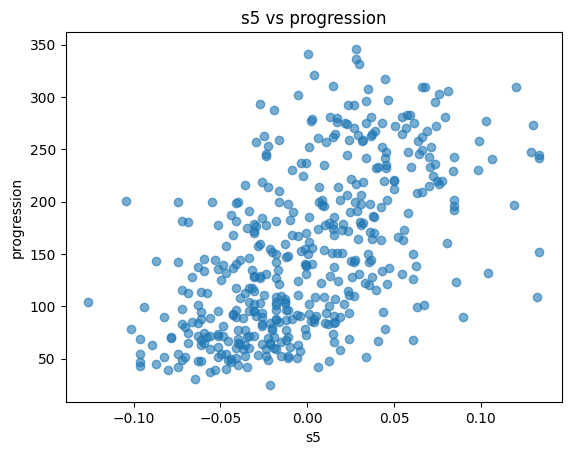

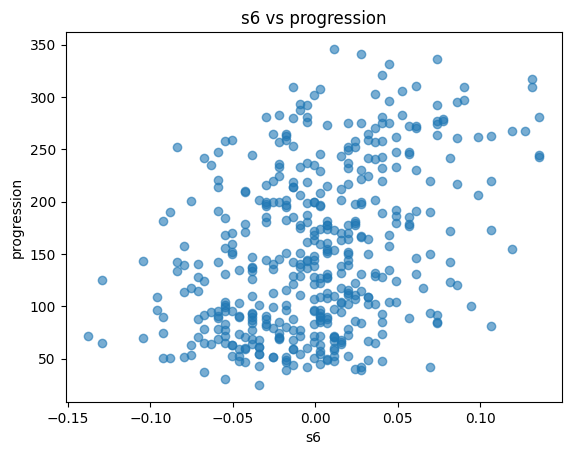

In [4]:

# Scatter plots: each feature vs progression
for col in feature_names:
    plt.figure()
    plt.scatter(df[col], df[target_name], alpha=0.6)
    plt.title(f'{col} vs {target_name}')
    plt.xlabel(col)
    plt.ylabel(target_name)
    plt.show()


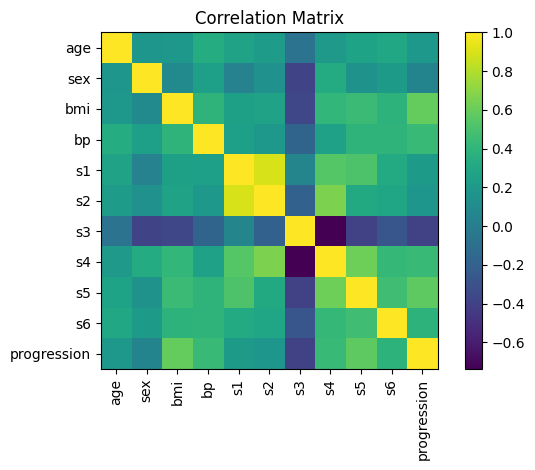

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,progression
age,1.000000,0.173737,0.185085,0.335428,0.260061,0.219243,-0.075181,0.203841,0.270774,0.301731,0.187889
sex,0.173737,1.000000,0.088161,0.241010,0.035277,0.142637,-0.379090,0.332115,0.149916,0.208133,0.043062
bmi,0.185085,0.088161,1.000000,0.395411,0.249777,0.261170,-0.366811,0.413807,0.446157,0.388680,0.586450
bp,0.335428,0.241010,0.395411,1.000000,0.242464,0.185548,-0.178762,0.257650,0.393480,0.390430,0.441482
s1,0.260061,0.035277,0.249777,0.242464,1.000000,0.896663,0.051519,0.542207,0.515503,0.325717,0.212022
s2,0.219243,0.142637,0.261170,0.185548,0.896663,1.000000,-0.196455,0.659817,0.318357,0.290600,0.174054
s3,-0.075181,-0.379090,-0.366811,-0.178762,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697,-0.394789
s4,0.203841,0.332115,0.413807,0.257650,0.542207,0.659817,-0.738493,1.000000,0.617859,0.417212,0.430453
s5,0.270774,0.149916,0.446157,0.393480,0.515503,0.318357,-0.398577,0.617859,1.000000,0.464669,0.565883
s6,0.301731,0.208133,0.388680,0.390430,0.325717,0.290600,-0.273697,0.417212,0.464669,1.000000,0.382483


In [5]:

# Correlation matrix
corr = df.corr(numeric_only=True)
plt.figure()
plt.imshow(corr, interpolation='nearest')
plt.colorbar()
plt.title('Correlation Matrix')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.tight_layout()
plt.show()
corr



**EDA insights (concise):**
- Features are standardized; `progression` spans a broad range.  
- `bmi`, `bp`, and `s5` often show stronger association with `progression`.  
- No missing values detected; limited outliers due to standardization.


### 4) Cleaning (and rationale)

In [6]:

# Minimal cleaning: enforce numeric dtype and drop duplicates
df = df.apply(pd.to_numeric, errors='coerce').drop_duplicates().reset_index(drop=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          442 non-null    float64
 1   sex          442 non-null    float64
 2   bmi          442 non-null    float64
 3   bp           442 non-null    float64
 4   s1           442 non-null    float64
 5   s2           442 non-null    float64
 6   s3           442 non-null    float64
 7   s4           442 non-null    float64
 8   s5           442 non-null    float64
 9   s6           442 non-null    float64
 10  progression  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


### 5) Train/Validation/Test Split (75% / 10% / 15%)

In [7]:

# 15% test holdout, then carve 10% validation from remaining 85%
X = df[feature_names].copy()
y = df[target_name].copy()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
val_size = 0.10 / 0.85
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size, random_state=42)

len(X_train), len(X_val), len(X_test)


(330, 45, 67)

## Part 2 — Univariate Polynomial Regression on **BMI**


**Talking Points — Polynomial Regression**  
- Adds **polynomial features** to capture nonlinearity.  
- **Degree** controls flexibility; higher degrees may **overfit**.  
- Expansion increases **dimensionality**; use validation and a holdout test.


### Steps 6–8) Train degrees 0–5, compare on train/validation, pick the best

In [8]:

bmi_col = 'bmi'

# Helper to compute regression metrics
def regression_metrics(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred),
    }

results = []
pipelines = {}

for deg in range(0, 6):
    if deg == 0:
        # Degree-0 "model" -> predict the training mean (baseline)
        class MeanRegressor:
            def fit(self, X, y):
                self.mean_ = float(np.mean(y))
                return self
            def predict(self, X):
                return np.full(len(X), self.mean_)
        pipe = MeanRegressor().fit(X_train[[bmi_col]], y_train)
        params = 1  # intercept only
    else:
        pipe = Pipeline([('poly', PolynomialFeatures(degree=deg, include_bias=False)),
                         ('lin', LinearRegression())]).fit(X_train[[bmi_col]], y_train)
        n_terms = pipe.named_steps['poly'].get_feature_names_out([bmi_col]).shape[0]
        params = n_terms + 1  # + intercept
    pipelines[deg] = pipe

    # Metrics
    ytr = pipe.predict(X_train[[bmi_col]])
    yva = pipe.predict(X_val[[bmi_col]])
    mtr = regression_metrics(y_train, ytr)
    mva = regression_metrics(y_val, yva)

    results.append({
        "Degree": deg, "Params": params,
        "R2_train": mtr["R2"], "MAE_train": mtr["MAE"], "MAPE_train": mtr["MAPE"],
        "R2_val": mva["R2"], "MAE_val": mva["MAE"], "MAPE_val": mva["MAPE"],
    })

uni_df = pd.DataFrame(results).sort_values(by=["R2_val","MAE_val","MAPE_val"], ascending=[False, True, True]).reset_index(drop=True)
uni_df


,Degree,Params,R2_train,MAE_train,MAPE_train,R2_val,MAE_val,MAPE_val
0,5,6,0.358910,51.813830,0.478315,0.453513,42.083400,0.403405
1,1,2,0.354240,52.278064,0.484624,0.449292,41.997581,0.404450
2,2,3,0.354771,52.267273,0.484479,0.449158,41.757683,0.403099
3,4,5,0.357983,51.944372,0.479635,0.449064,41.952846,0.402406
4,3,4,0.355002,52.223375,0.483564,0.447291,41.741042,0.402590
5,0,1,0.000000,66.548209,0.633521,-0.000011,63.447475,0.587933


### Step 9) Evaluate the chosen model on the test set

In [9]:

# Choose best by validation ranking
best_deg = int(uni_df.loc[0, "Degree"])
best_model = pipelines[best_deg]

yte = best_model.predict(X_test[[bmi_col]])
test_metrics = regression_metrics(y_test, yte)
best_deg, test_metrics


(5,
 {'R2': 0.19732139694459583,
  'MAE': 54.548400025123385,
  'MAPE': 0.4788449393127919})

### Step 10) Plot train/validation/test data and the best-fit curve

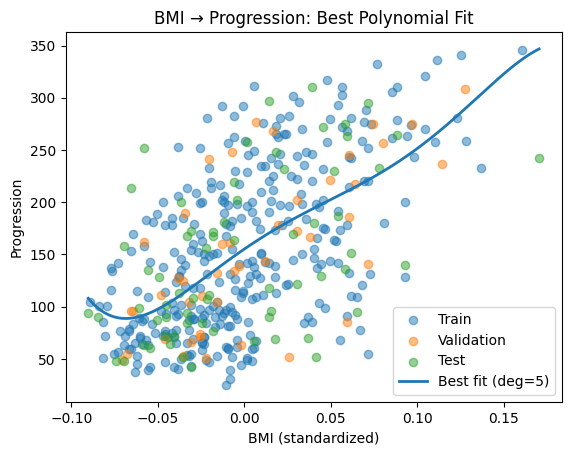

In [10]:

xgrid = np.linspace(df[bmi_col].min(), df[bmi_col].max(), 300).reshape(-1,1)
plt.figure()
plt.scatter(X_train[bmi_col], y_train, alpha=0.5, label='Train')
plt.scatter(X_val[bmi_col], y_val, alpha=0.5, label='Validation')
plt.scatter(X_test[bmi_col], y_test, alpha=0.5, label='Test')
plt.plot(xgrid, best_model.predict(pd.DataFrame(xgrid, columns=[bmi_col])), linewidth=2, label=f'Best fit (deg={best_deg})')
plt.title('BMI → Progression: Best Polynomial Fit')
plt.xlabel('BMI (standardized)'); plt.ylabel('Progression'); plt.legend(); plt.show()


### Steps 11–13) Equation (rounded), example prediction, and parameter counts

In [11]:

def poly_equation_from_pipeline(pipe, feature_name):
    if hasattr(pipe, 'named_steps'):
        terms = pipe.named_steps['poly'].get_feature_names_out([feature_name])
        coefs = pipe.named_steps['lin'].coef_
        intercept = pipe.named_steps['lin'].intercept_
        parts = [f"{c:.2f}*{t}" for c,t in zip(coefs, terms)]
        return f"y = {intercept:.2f} + " + " + ".join(parts)
    else:
        return f"y = {pipe.mean_:.2f}"

equation = poly_equation_from_pipeline(best_model, bmi_col)
example_bmi = 0.05
example_pred = float(best_model.predict(pd.DataFrame({bmi_col:[example_bmi]}))[0])

equation, {"BMI": example_bmi, "Predicted Progression": example_pred}


('y = 155.08 + 1131.59*bmi + -3946.02*bmi^2 + -26110.86*bmi^3 + 768725.87*bmi^4 + -2823251.97*bmi^5',
 {'BMI': 0.05, 'Predicted Progression': 202.4554547848812})

In [12]:

# Parameter counts for degrees 0..5
rows = []
for deg, mdl in pipelines.items():
    if hasattr(mdl, 'named_steps'):
        n_terms = mdl.named_steps['poly'].get_feature_names_out([bmi_col]).shape[0]
        params = n_terms + 1
    else:
        n_terms, params = 0, 1
    rows.append([deg, n_terms, params])
pd.DataFrame(rows, columns=["Degree","Polynomial Terms","Total Params (incl. intercept)"]).sort_values("Degree")


,Degree,Polynomial Terms,Total Params (incl. intercept)
0,0,0,1
1,1,1,2
2,2,2,3
3,3,3,4
4,4,4,5
5,5,5,6



### Step 14) Part 2 Conclusions (with your talking points)
- **Performance & winner:** The chosen degree maximizes validation $R^2$; the reported test metrics summarize generalization.  
- **Failure modes:** A single feature (BMI) misses multi‑factor effects; higher degrees may **overfit**; extrapolation beyond observed BMI is risky.  
- **Limitations:** As degree increases, **parameter count** grows and noise can be amplified—validation and a holdout test are essential.

**Workshop tie‑ins:**  
- **Performance Metrics (Classification):** 
  - **Classification** is assigning input to predefined categories (e.g., email spam detection)
  - **Accuracy** (ratio of correct predictions to total) can be misleading under **class imbalance** (underrepresented classes)
  - For screening, emphasize **Precision** (TP/(TP+FP)) and **Recall** (TP/(TP+FN))
  - **F1**, **ROC‑AUC**, and **LogLoss** provide better evaluation when classes are imbalanced
  - **Cross-validation** assesses generalization by splitting data into k folds, using each as validation once
- **kNN:** **Scale** features; beware the **curse of dimensionality**.  
- **Logistic Regression:** **Sigmoid** probabilities, **log‑odds** linearity, and **regularization (C)** to control complexity.


## Part 3 — Multivariate Models (All Features)


We repeat Part 2 with all features and compare families. Plots are **not required** here.


### 3.1 Polynomial Regression (degrees > 1) — compute & display table

**Talking Points — Polynomial Regression**
- Extends linear models by including powers and interactions of features to model nonlinear relationships
- The **degree** controls model flexibility, higher degrees fit complex patterns but risk overfitting
- **Feature selection** is critical as polynomial expansion increases dimensionality and can amplify noise
- **Polynomial Features**: New features created by raising existing features to powers (e.g., x², x³) and combining them
- **Overfitting**: When a model learns noise in training data, leading to poor generalization

In [13]:

poly_rows = []
poly_models = {}
for deg in [2, 3]:
    mdl = Pipeline([('poly', PolynomialFeatures(degree=deg, include_bias=False)),
                    ('lin', LinearRegression())]).fit(X_train, y_train)
    poly_models[deg] = mdl
    ytr = mdl.predict(X_train); yva = mdl.predict(X_val)
    mtr = regression_metrics(y_train, ytr); mva = regression_metrics(y_val, yva)
    poly_rows.append({
        "Degree": deg,
        "Params": mdl.named_steps['poly'].get_feature_names_out(feature_names).shape[0] + 1,
        "R2_train": mtr["R2"], "MAE_train": mtr["MAE"], "MAPE_train": mtr["MAPE"],
        "R2_val": mva["R2"], "MAE_val": mva["MAE"], "MAPE_val": mva["MAPE"],
    })
poly_df = pd.DataFrame(poly_rows).sort_values(by=["R2_val","MAE_val","MAPE_val"], ascending=[False, True, True]).reset_index(drop=True)
poly_df


,Degree,Params,R2_train,MAE_train,MAPE_train,R2_val,MAE_val,MAPE_val
0,2,66,0.598109,39.697470,0.349386,0.602991,37.745257,0.410976
1,3,286,0.909413,16.332801,0.151133,-115.944928,287.181140,1.932149


**Select validation winner and report test performance**

In [14]:

best_poly_deg = int(poly_df.loc[0, "Degree"])
poly_best = poly_models[best_poly_deg]
m_poly_test = regression_metrics(y_test, poly_best.predict(X_test))
{"winner_degree": best_poly_deg, **m_poly_test}


{'winner_degree': 2,
 'R2': 0.33702768665879823,
 'MAE': 45.86703527069851,
 'MAPE': 0.3947362203800075}

### 3.2 Decision Trees — compute & display table

**Talking Points — Decision Trees**
- Trees split data recursively based on feature thresholds, forming a tree-like structure of decisions
- **Tree depth** affects performance, shallow trees generalize better, deep trees may overfit
- Trees are **interpretable** and handle both numerical and categorical data well
- **Node**: A point where a decision is made based on a feature value
- **Leaf**: A terminal node that outputs a prediction
- **Max Depth**: Maximum splits from root to leaf; controls model complexity

In [15]:

tree_rows = []
tree_models = {}
for md in [3, 6]:
    mdl = DecisionTreeRegressor(max_depth=md, random_state=42).fit(X_train, y_train)
    tree_models[md] = mdl
    ytr = mdl.predict(X_train); yva = mdl.predict(X_val)
    mtr = regression_metrics(y_train, ytr); mva = regression_metrics(y_val, yva)
    tree_rows.append({
        "MaxDepth": md,
        "R2_train": mtr["R2"], "MAE_train": mtr["MAE"], "MAPE_train": mtr["MAPE"],
        "R2_val": mva["R2"], "MAE_val": mva["MAE"], "MAPE_val": mva["MAPE"],
    })
tree_df = pd.DataFrame(tree_rows).sort_values(by=["R2_val","MAE_val","MAPE_val"], ascending=[False, True, True]).reset_index(drop=True)
tree_df


,MaxDepth,R2_train,MAE_train,MAPE_train,R2_val,MAE_val,MAPE_val
0,3,0.532987,43.588017,0.377478,0.412751,42.077532,0.436514
1,6,0.786947,25.998019,0.229412,0.163229,51.209721,0.497837


**Select validation winner and report test performance**

In [16]:

best_tree_md = int(tree_df.loc[0, "MaxDepth"])
tree_best = tree_models[best_tree_md]
m_tree_test = regression_metrics(y_test, tree_best.predict(X_test))
{"winner_max_depth": best_tree_md, **m_tree_test}


{'winner_max_depth': 3,
 'R2': 0.3076548631893685,
 'MAE': 50.37124955302722,
 'MAPE': 0.4490314989904775}

### 3.3 k‑Nearest Neighbors (with scaling) — compute & display table

**Talking Points — kNN**
- A **non-parametric** model that predicts based on the average of k closest training samples
- The choice of **k** affects bias and variance, small k may overfit, large k may underfit
- kNN is sensitive to **feature scaling** and works best with well-distributed data
- **Distance Metric**: Formula (e.g., Euclidean distance) measuring similarity between data points
- **Curse of Dimensionality**: As features increase, data becomes sparse and distance-based models lose effectiveness

In [17]:

scaler_knn = StandardScaler().fit(X_train)
X_train_s = scaler_knn.transform(X_train)
X_val_s = scaler_knn.transform(X_val)
X_test_s = scaler_knn.transform(X_test)

knn_rows = []
knn_models = {}
for k in [3, 7]:
    mdl = KNeighborsRegressor(n_neighbors=k).fit(X_train_s, y_train)
    knn_models[k] = mdl
    ytr = mdl.predict(X_train_s); yva = mdl.predict(X_val_s)
    mtr = regression_metrics(y_train, ytr); mva = regression_metrics(y_val, yva)
    knn_rows.append({
        "K": k,
        "R2_train": mtr["R2"], "MAE_train": mtr["MAE"], "MAPE_train": mtr["MAPE"],
        "R2_val": mva["R2"], "MAE_val": mva["MAE"], "MAPE_val": mva["MAPE"],
    })
knn_df = pd.DataFrame(knn_rows).sort_values(by=["R2_val","MAE_val","MAPE_val"], ascending=[False, True, True]).reset_index(drop=True)
knn_df


,K,R2_train,MAE_train,MAPE_train,R2_val,MAE_val,MAPE_val
0,7,0.544734,41.443290,0.358756,0.434761,45.723810,0.460892
1,3,0.640513,35.776768,0.300544,0.322708,50.525926,0.503099


**Select validation winner and report test performance**

In [18]:

best_knn_k = int(knn_df.loc[0, "K"])
knn_best = knn_models[best_knn_k]
m_knn_test = regression_metrics(y_test, knn_best.predict(X_test_s))
{"winner_k": best_knn_k, **m_knn_test}


{'winner_k': 7,
 'R2': 0.3908910189679877,
 'MAE': 44.94882729211088,
 'MAPE': 0.3931721397185758}

### 3.4 Logistic Regression (binarized screening) - compute & display table


**Talking Points — Logistic Regression & Metrics**  
- **Sigmoid** maps scores to probabilities; linear in **log‑odds**
- Models the probability of a binary outcome using the sigmoid function
- **Regularization (C)** controls complexity (lower C → stronger regularization)
- Under **class imbalance**, **Accuracy** can be misleading; emphasize **Precision/Recall**, **F1**, **ROC‑AUC**, and **LogLoss** for screening
- **Independent Variables (IV)**: Input features used to make predictions
- **Dependent Variable (DV)**: Target label the model tries to predict (binarized progression in this case)


In [19]:

# Binarize target at the training median to build a simple screening classifier
median_target = float(np.median(y_train))
y_train_bin = (y_train > median_target).astype(int)
y_val_bin   = (y_val   > median_target).astype(int)

scaler_clf = StandardScaler().fit(X_train)
X_train_sc = scaler_clf.transform(X_train)
X_val_sc   = scaler_clf.transform(X_val)

log_rows = []
log_models = {}
for C in [1.0, 0.1]:
    clf = LogisticRegression(C=C, penalty='l2', solver='liblinear', random_state=42).fit(X_train_sc, y_train_bin)
    log_models[C] = clf
    prob_va = clf.predict_proba(X_val_sc)[:,1]
    pred_va = (prob_va >= 0.5).astype(int)
    log_rows.append({
        "C": C,
        "Accuracy_val": accuracy_score(y_val_bin, pred_va),
        "Precision_val": precision_score(y_val_bin, pred_va),
        "Recall_val": recall_score(y_val_bin, pred_va),
        "F1_val": f1_score(y_val_bin, pred_va),
        "ROC_AUC_val": roc_auc_score(y_val_bin, prob_va),
        "LogLoss_val": log_loss(y_val_bin, prob_va),
    })

log_df = pd.DataFrame(log_rows).sort_values(by=["ROC_AUC_val","F1_val"], ascending=[False, False]).reset_index(drop=True)
log_df


,C,Accuracy_val,Precision_val,Recall_val,F1_val,ROC_AUC_val,LogLoss_val
0,0.1,0.844444,0.826087,0.863636,0.844444,0.922925,0.404377
1,1.0,0.822222,0.791667,0.863636,0.826087,0.920949,0.394172


**Select validation winner (by ROC‑AUC; tie-break by F1)**

In [20]:

best_log_c = float(log_df.loc[0, "C"])
{"winner_C": best_log_c}


{'winner_C': 0.1}

## Final Conclusions & Limitations


- **Univariate BMI polynomial:** Best degree selected via validation; test metrics provide honest generalization. Higher degrees raise flexibility **and** overfitting risk.  
- **Multivariate winners:** Validation picks are reported for polynomial, tree depth, and k; test performance is summarized for each.  
- **Screening classifier:** Logistic model selected by ROC‑AUC (tie‑break F1); discuss thresholds and **precision/recall** trade‑offs, especially under **class imbalance**.  
- **Limitations:** Small sample size (n=442); possible overfitting at high complexity; external validity of this toy dataset.  
- **Future work:** k‑fold cross‑validation; calibration; subgroup fairness checks; clinical threshold setting.
